In [1]:
%run Imports.ipynb
from quantpy.tomography.interval import ConfidenceInterval, _pop_hidden_keys, Mode

import numpy as np
import scipy.linalg as la
import scipy.stats as sts
import math

from enum import Enum, auto
from abc import ABC, abstractmethod
from scipy.interpolate import interp1d
from collections import Counter, defaultdict
from functools import partial

from quantpy.geometry import hs_dst, trace_dst, if_dst
from quantpy.qobj import Qobj
from quantpy.routines import (
    _left_inv, _vec2mat, _mat2vec,
    _matrix_to_real_tril_vec, _real_tril_vec_to_matrix,
)

from abc import ABC, abstractmethod
from enum import Enum, auto

import numpy as np
import scipy.stats as sts
from cvxopt import matrix, solvers
from einops import rearrange, repeat
from scipy.interpolate import interp1d

from quantpy.geometry import hs_dst, if_dst, trace_dst
from quantpy.mhmc import MHMC, normalized_update
from quantpy.routines import _left_inv, _mat2vec, _matrix_to_real_tril_vec, _real_tril_vec_to_matrix, _vec2mat
from quantpy.stats import l2_mean, l2_variance
from quantpy.tomography.polytopes.utils import count_confidence, count_delta

titlesize = 40
labelsize = 50
legendsize = 32
xticksize = 38
yticksize = xticksize
linewidth = 3
fontsize = 54
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize
matplotlib.rcParams['font.size'] = fontsize
matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)

In [2]:
depolarizator = qp.channel.depolarizing(p=0.1, n_qubits=2)
target_state = qp.qobj.GHZ(n_qubits=2)
dim = 2 ** target_state.n_qubits
state = depolarizator.transform(target_state)
fidelity = np.dot(target_state.bloch, state.bloch) * dim

In [6]:
depolarizator = qp.channel.depolarizing(p=0.1, n_qubits=2)
target_state = qp.qobj.GHZ(n_qubits=2)
dim = 2 ** target_state.n_qubits
state = depolarizator.transform(target_state)
fidelity = np.dot(target_state.bloch, state.bloch) * dim
epsilons = np.logspace(-5, -0.01, 100)
conf_levels = 1 - epsilons

results = defaultdict(list)

for i in tqdm(range(100)):
    for n_measurements in [10 ** 3, 10 ** 4, 10 ** 5]:
        tmg = qp.StateTomograph(state)
        tmg.experiment(n_measurements, povm="proj-set")
        interval = qp.PolytopeStateInterval(tmg, target_state=target_state)
        (dist_min, dist_max), _ = interval(conf_levels)
        results[(n_measurements, "min")].append(dist_min)
        results[(n_measurements, "max")].append(dist_max)
        
with open(f'../results/thesis/fidelity_ghz.pkl', 'wb') as file:
    pickle.dump(results, file)

  0%|          | 0/100 [00:00<?, ?it/s]

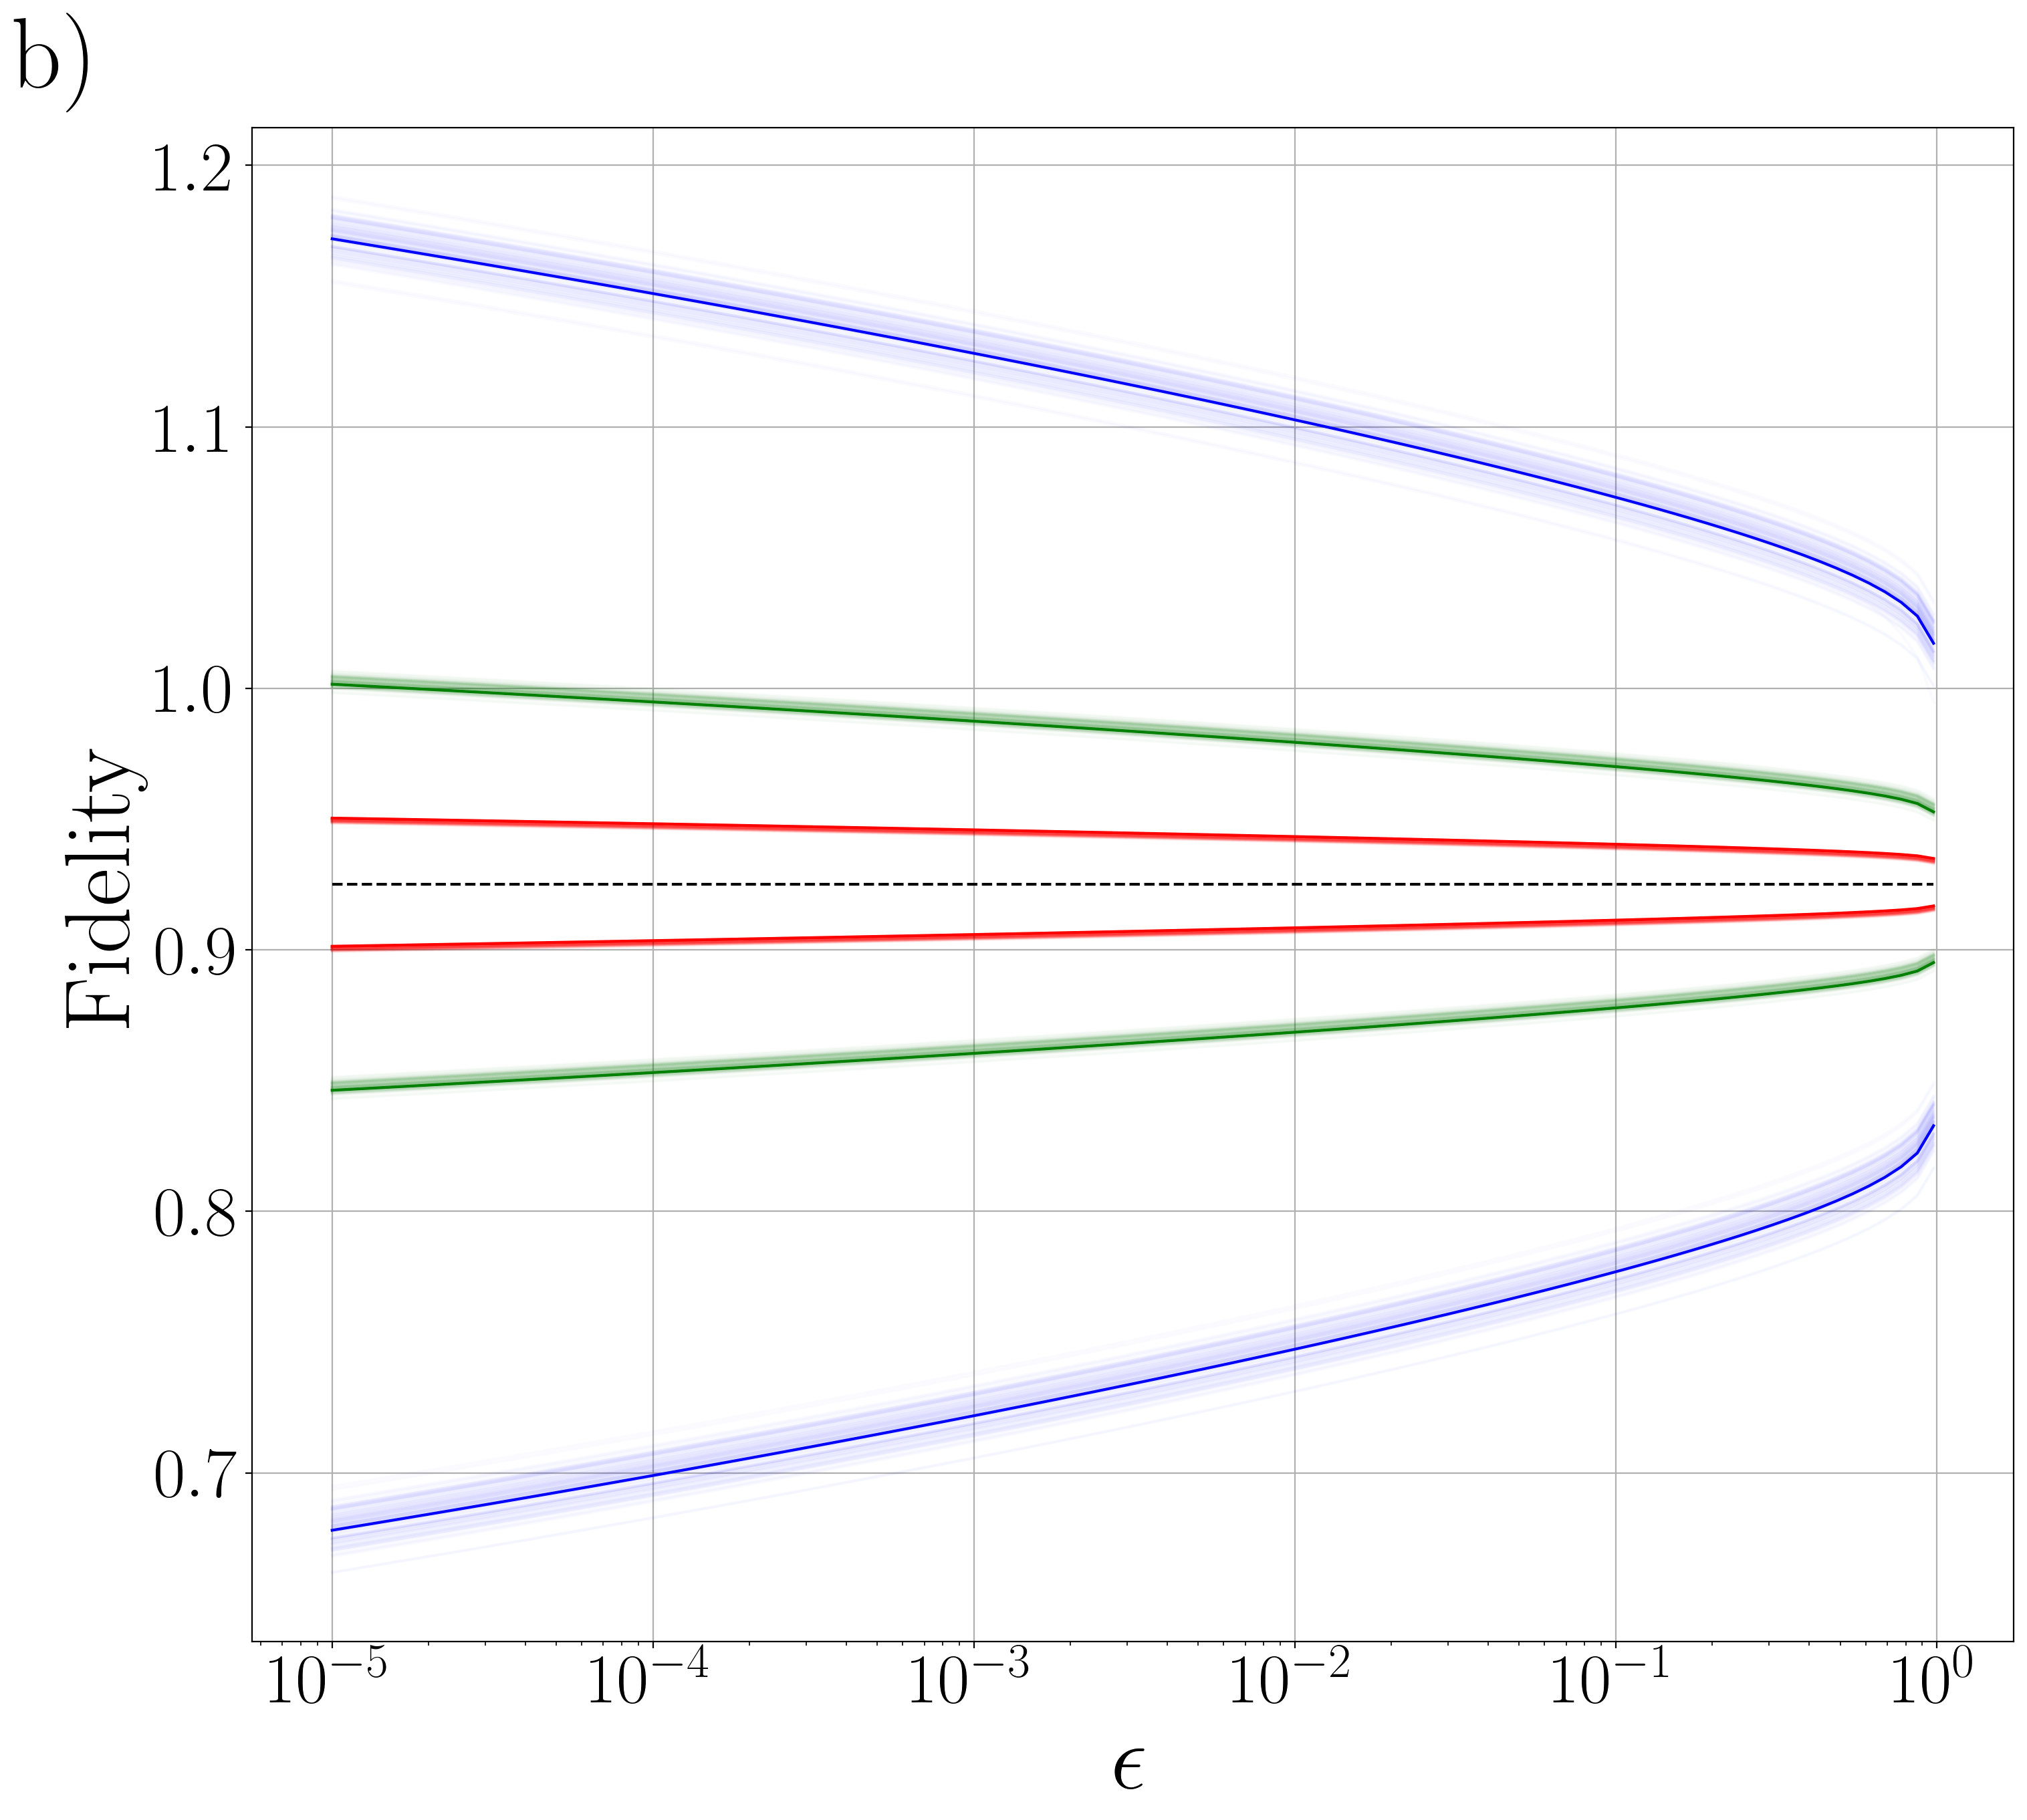

In [17]:
with open(f'../results/thesis/fidelity_ghz.pkl', 'rb') as file:
    results = pickle.load(file)
fidelity = 0.925
plt.figure(figsize=(17, 15), dpi=200)
plt.xlabel('$\\epsilon$')
plt.ylabel('Fidelity')
plt.grid()

for n_measurements, color in zip([10 ** 3, 10 ** 4, 10 ** 5], ["b", "g", "r"]):
    for i, (dist_min, dist_max) in enumerate(zip(results[(n_measurements, "min")], results[(n_measurements, "max")])):
        alpha = 1 if i == 0 else 0.02
        plt.plot(epsilons, dist_min, c=color, alpha=alpha)
        plt.plot(epsilons, dist_max, c=color, alpha=alpha)
    
plt.plot([epsilons[0], epsilons[-1]], [fidelity] * 2, '--k')
plt.xscale('log')
plt.figtext(0.02, 0.9, "b)")
plt.savefig('../imgs/thesis/fidelity_ghz.pdf')

In [19]:
target_channel = qp.channel.depolarizing(p=0, n_qubits=1)
channel = qp.channel.depolarize(target_channel, 0.1)

In [24]:
target_channel.choi @ channel.choi

Quantum object
array([[ 0.925+0.j,  0.925+0.j,  0.925+0.j, -0.925+0.j],
       [ 0.925+0.j,  0.925+0.j,  0.925+0.j, -0.925+0.j],
       [ 0.925+0.j,  0.925+0.j,  0.925+0.j, -0.925+0.j],
       [-0.925+0.j, -0.925+0.j, -0.925+0.j,  0.925+0.j]])

In [3]:
target_channel = qp.operator.Id.as_channel()
channel = qp.channel.depolarize(target_channel, 0.1)
dim = 2 ** target_channel.n_qubits
fidelity = np.dot(target_channel.choi.bloch, channel.choi.bloch)
epsilons = np.logspace(-5, -0.01, 100)
conf_levels = 1 - epsilons

results = defaultdict(list)

for i in tqdm(range(100)):
    for n_measurements in [10 ** 3, 10 ** 4, 10 ** 5]:
        tmg = qp.ProcessTomograph(channel)
        tmg.experiment(n_measurements, povm="proj-set")
        interval = qp.tomography.interval.MomentFidelityProcessInterval(tmg, target_process=target_channel)
        (dist_min, dist_max), _ = interval(conf_levels)
        results[(n_measurements, "min")].append(dist_min)
        results[(n_measurements, "max")].append(dist_max)
        
# with open(f'../results/thesis/fidelity_hadamard.pkl', 'wb') as file:
#     pickle.dump(results, file)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
with open(f'../data/fidelity_dep.pkl', 'wb') as file:
    pickle.dump(results, file)

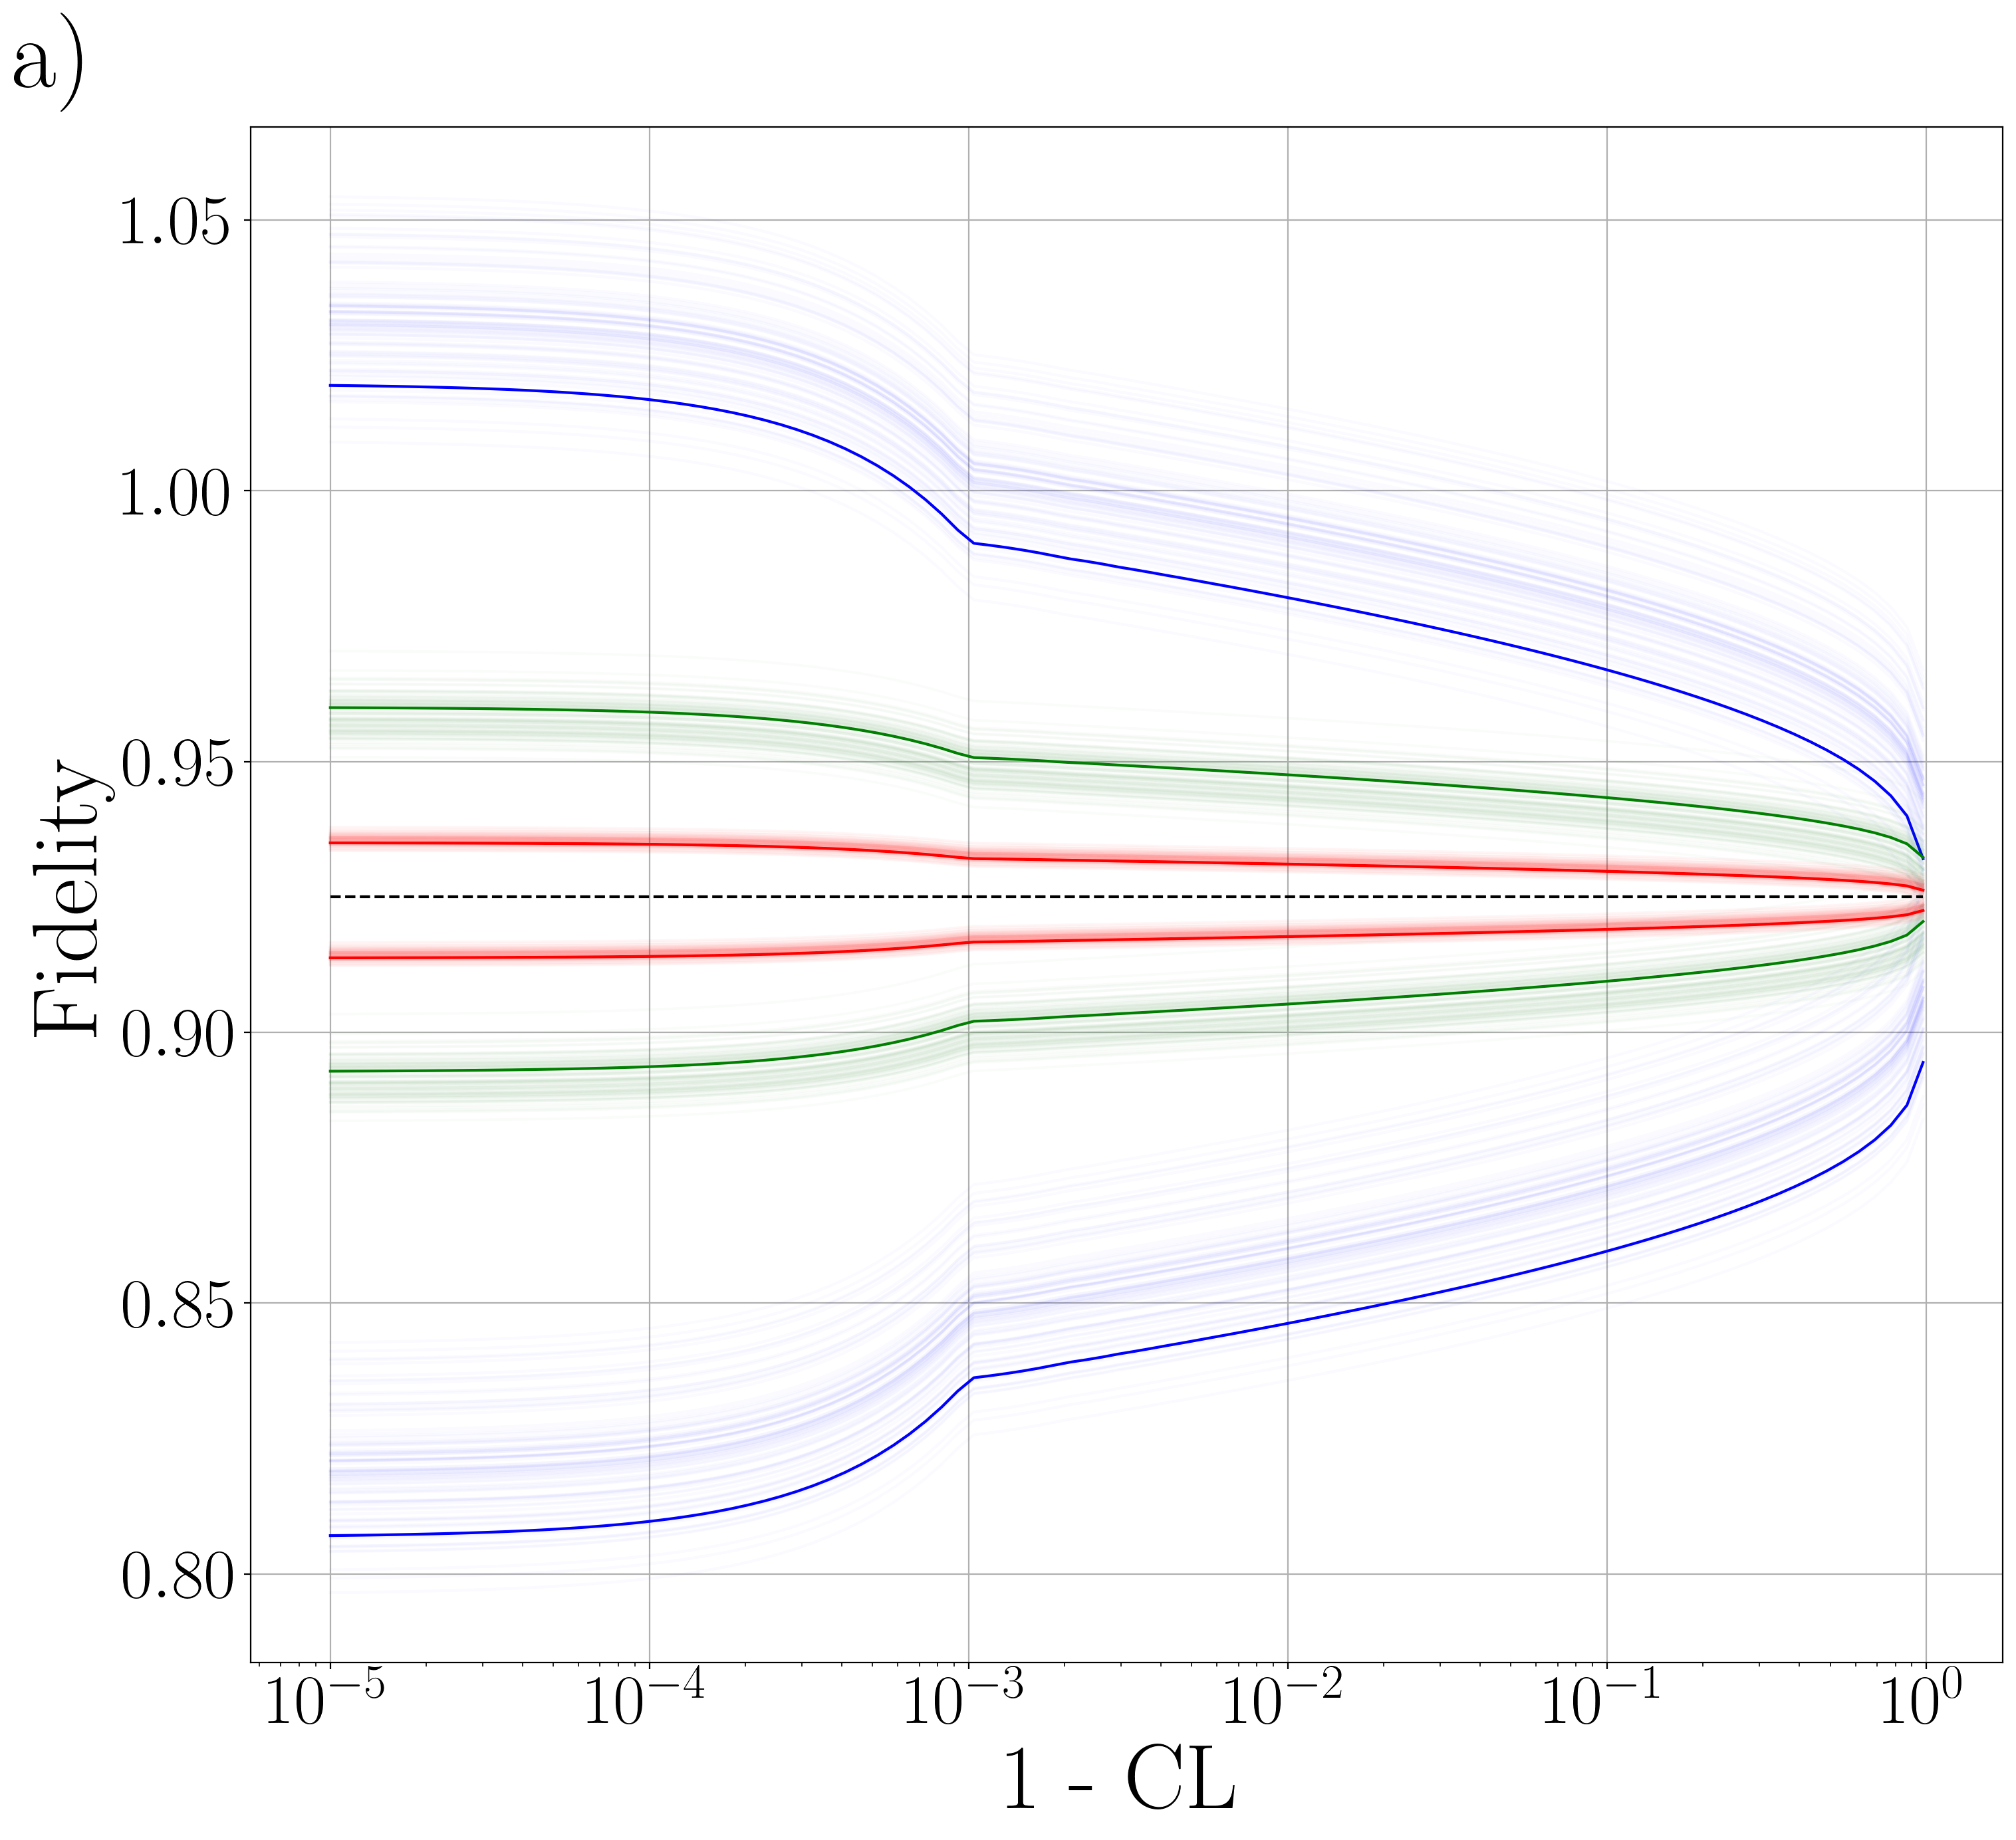

In [4]:
# with open(f'../results/thesis/fidelity_hadamard.pkl', 'rb') as file:
#     results = pickle.load(file)
fidelity = 0.925

plt.figure(figsize=(17, 15), dpi=200)
plt.xlabel('1 - CL')
plt.ylabel('Fidelity')
plt.grid()

for n_measurements, color in zip([10 ** 3, 10 ** 4, 10 ** 5], ["b", "g", "r"]):
    for i, (dist_min, dist_max) in enumerate(zip(results[(n_measurements, "min")], results[(n_measurements, "max")])):
        alpha = 1 if i == 0 else 0.02
        plt.plot(epsilons, dist_min, c=color, alpha=alpha)
        plt.plot(epsilons, dist_max, c=color, alpha=alpha)
    
plt.plot([epsilons[0], epsilons[-1]], [fidelity] * 2, '--k')
plt.xscale('log')
plt.figtext(0.02, 0.9, "a)")
plt.savefig('../data/fig_2b.pdf')

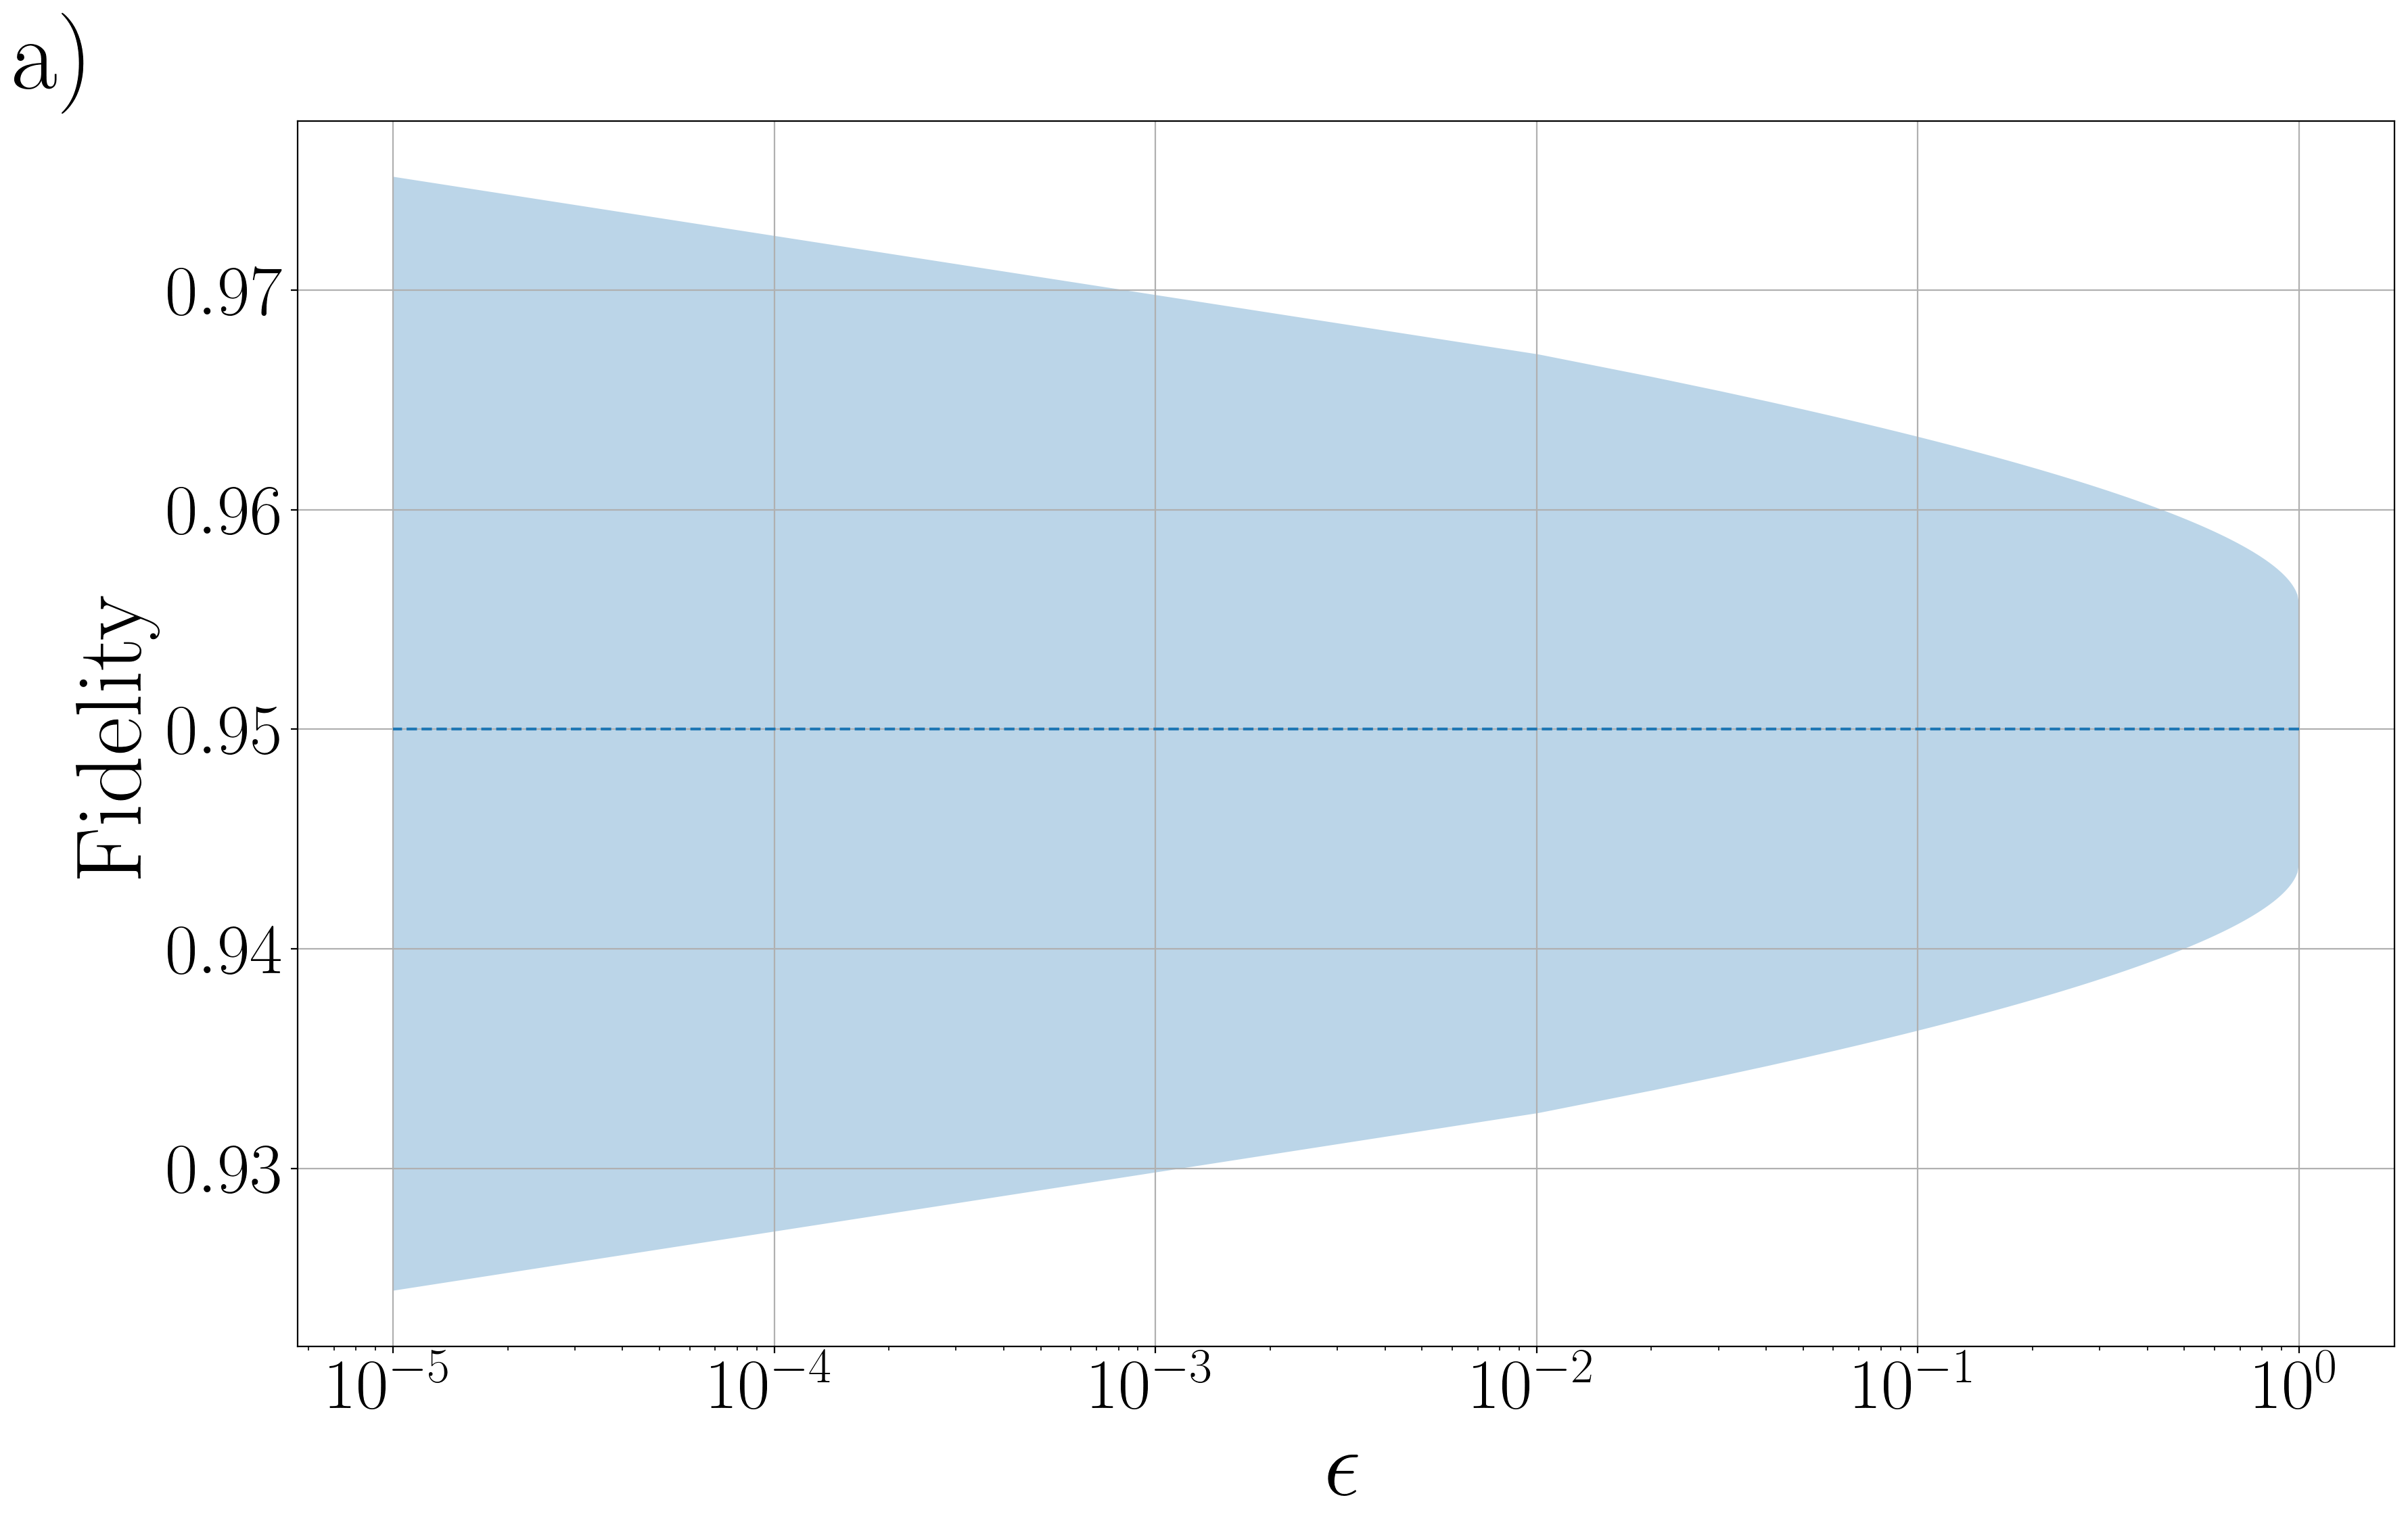

In [11]:
plt.figure(figsize=(20, 12), dpi=200)
plt.xlabel('$\\epsilon$')
plt.ylabel('Fidelity')
plt.grid()
plt.fill_between(epsilons, dist_min, dist_max, alpha=0.3)
plt.xscale('log')
plt.figtext(0.02, 0.9, "a)")
plt.savefig('../imgs/thesis/fidelity_zero.pdf')

In [ ]:
target_channel = qp.operator.Id.as_channel()
tmg = qp.ProcessTomograph(target_channel, input_states=input_basis)
tmg.experiment(8192, povm_matrix)